Iteration 0/300 - Best Cost: 9955.61
Iteration 10/300 - Best Cost: 8350.88
Iteration 20/300 - Best Cost: 8296.52
Iteration 30/300 - Best Cost: 8296.52
Iteration 40/300 - Best Cost: 8296.52
Iteration 50/300 - Best Cost: 8296.52
Iteration 60/300 - Best Cost: 8296.52
Iteration 70/300 - Best Cost: 8296.52
Iteration 80/300 - Best Cost: 8267.94
Iteration 90/300 - Best Cost: 8267.94
Iteration 100/300 - Best Cost: 8267.94
Iteration 110/300 - Best Cost: 8046.18
Iteration 120/300 - Best Cost: 7703.24
Iteration 130/300 - Best Cost: 7703.24
Iteration 140/300 - Best Cost: 7703.24
Iteration 150/300 - Best Cost: 7639.56
Iteration 160/300 - Best Cost: 7639.56
Iteration 170/300 - Best Cost: 7639.56
Iteration 180/300 - Best Cost: 7639.56
Iteration 190/300 - Best Cost: 7639.56
Iteration 200/300 - Best Cost: 7639.56
Iteration 210/300 - Best Cost: 7639.56
Iteration 220/300 - Best Cost: 7639.56
Iteration 230/300 - Best Cost: 7639.56
Iteration 240/300 - Best Cost: 7639.56
Iteration 250/300 - Best Cost: 7639.

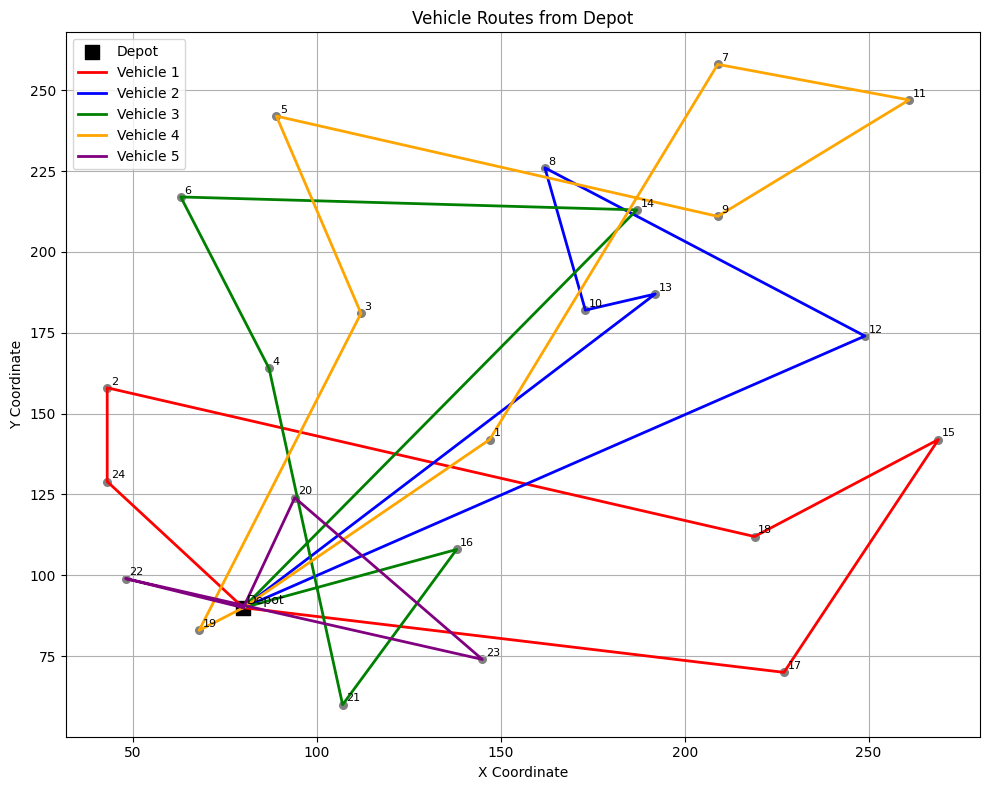

In [3]:
import random
import math
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML

# Constants
COST_PER_KM = 2.5
FIXED_COST_PER_VEHICLE = 100
START_TIME = 300  # 5:00 AM in minutes
SERVICE_TIME = 3
VEHICLE_COUNT = 5
VEHICLE_CAPACITY = 1100
POP_SIZE = 100
GENERATION_COUNT = 300

# Depot and customers
depot = {"id": 0, "x": 80, "y": 90}
customers = [
    {"id": 1, "x": 147, "y": 142, "demand": 48, "required": (340, 380), "acceptable": (300, 420)},
    {"id": 2, "x": 43, "y": 158, "demand": 143, "required": (580, 620), "acceptable": (540, 660)},
    {"id": 3, "x": 112, "y": 181, "demand": 149, "required": (1020, 1060), "acceptable": (980, 1100)},
    {"id": 4, "x": 87, "y": 164, "demand": 77, "required": (300, 340), "acceptable": (640, 760)},
    {"id": 5, "x": 89, "y": 242, "demand": 216, "required": (940, 980), "acceptable": (900, 1020)},
    {"id": 6, "x": 63, "y": 217, "demand": 279, "required": (740, 780), "acceptable": (700, 820)},
    {"id": 7, "x": 209, "y": 258, "demand": 163, "required": (332, 372), "acceptable": (292, 412)},
    {"id": 8, "x": 162, "y": 226, "demand": 132, "required": (1104, 1144), "acceptable": (1064, 1184)},
    {"id": 9, "x": 209, "y": 211, "demand": 231, "required": (748, 788), "acceptable": (708, 828)},
    {"id": 10, "x": 173, "y": 182, "demand": 267, "required": (941, 981), "acceptable": (901, 1021)},
    {"id": 11, "x": 261, "y": 247, "demand": 91, "required": (514, 554), "acceptable": (474, 594)},
    {"id": 12, "x": 249, "y": 174, "demand": 308, "required": (1120, 1160), "acceptable": (1080, 1200)},
    {"id": 13, "x": 192, "y": 187, "demand": 264, "required": (681, 721), "acceptable": (641, 761)},
    {"id": 14, "x": 187, "y": 213, "demand": 315, "required": (803, 843), "acceptable": (763, 883)},
    {"id": 15, "x": 269, "y": 142, "demand": 191, "required": (1143, 1183), "acceptable": (1103, 1223)},
    {"id": 16, "x": 138, "y": 108, "demand": 102, "required": (417, 457), "acceptable": (377, 497)},
    {"id": 17, "x": 227, "y": 70, "demand": 328, "required": (1149, 1189), "acceptable": (1109, 1229)},
    {"id": 18, "x": 219, "y": 112, "demand": 283, "required": (1038, 1078), "acceptable": (998, 1118)},
    {"id": 19, "x": 68, "y": 83, "demand": 69, "required": (1186, 1226), "acceptable": (1146, 1266)},
    {"id": 20, "x": 94, "y": 124, "demand": 329, "required": (1064, 1104), "acceptable": (1024, 1144)},
    {"id": 21, "x": 107, "y": 60, "demand": 301, "required": (477, 517), "acceptable": (437, 557)},
    {"id": 22, "x": 48, "y": 99, "demand": 337, "required": (629, 669), "acceptable": (589, 709)},
    {"id": 23, "x": 145, "y": 74, "demand": 291, "required": (868, 908), "acceptable": (828, 948)},
    {"id": 24, "x": 43, "y": 129, "demand": 122, "required": (423, 463), "acceptable": (383, 503)},
]

def distance(a, b):
    return math.hypot(a["x"] - b["x"], a["y"] - b["y"])

def get_penalty_weights(generation, max_gen):
    base_early = 0.1
    base_late = 3.0
    early = base_early if generation < max_gen * 0.3 else 0.3
    late = base_late * (1 + (generation / max_gen) * 0.5)
    return early, late

def repair_solution(solution, early_w, late_w):
    for route in solution:
        if len(route) > 1:
            improved = True
            while improved:
                improved = False
                for i in range(len(route)):
                    for j in range(i + 1, len(route)):
                        new_route = route[:]
                        new_route[i], new_route[j] = new_route[j], new_route[i]
                        if route_timing_penalty(new_route, early_w, late_w) < route_timing_penalty(route, early_w, late_w):
                            route[:] = new_route
                            improved = True
    return solution

def route_timing_penalty(route, early_w, late_w):
    arrival = START_TIME
    penalty = 0
    prev = depot
    for cid in route:
        cust = next(c for c in customers if c["id"] == cid)
        arrival += distance(prev, cust)
        if arrival < cust["acceptable"][0]:
            penalty += (cust["acceptable"][0] - arrival) * early_w
            arrival = cust["acceptable"][0]
        elif arrival > cust["acceptable"][1]:
            penalty += (arrival - cust["acceptable"][1]) * late_w
        if arrival < cust["required"][0]:
            arrival = cust["required"][0]
        arrival += SERVICE_TIME
        prev = cust
    return penalty

def optimize_route_timing(route, early_w, late_w):
    best_route = route[:]
    best_penalty = route_timing_penalty(best_route, early_w, late_w)
    improved = True
    while improved:
        improved = False
        for i in range(len(route)):
            for j in range(i + 1, len(route)):
                new_route = best_route[:]
                new_route[i], new_route[j] = new_route[j], new_route[i]
                penalty = route_timing_penalty(new_route, early_w, late_w)
                if penalty < best_penalty:
                    best_penalty = penalty
                    best_route = new_route
                    improved = True
    return best_route

def evaluate_fitness(chromosome, generation):
    total_transport = 0
    total_penalty = 0
    total_fixed = 0
    early_w, late_w = get_penalty_weights(generation, GENERATION_COUNT)

    for route in chromosome:
        if not route:
            continue
        total_fixed += FIXED_COST_PER_VEHICLE
        load = 0
        cost = 0
        arrival = START_TIME
        prev = depot

        for cid in route:
            customer = next(c for c in customers if c["id"] == cid)
            load += customer["demand"]
            dist = distance(prev, customer)
            arrival += dist

            if arrival < customer["acceptable"][0]:
                total_penalty += (customer["acceptable"][0] - arrival) * early_w
                arrival = customer["acceptable"][0]
            elif arrival > customer["acceptable"][1]:
                total_penalty += (arrival - customer["acceptable"][1]) * late_w

            if arrival < customer["required"][0]:
                arrival = customer["required"][0]

            arrival += SERVICE_TIME
            cost += dist * COST_PER_KM
            prev = customer

        cost += distance(prev, depot) * COST_PER_KM
        total_transport += cost

        if load > VEHICLE_CAPACITY:
            total_penalty += (load - VEHICLE_CAPACITY) * 1000

    total_cost = total_transport + total_penalty + total_fixed
    fitness = 1 / (1 + total_cost)
    return fitness, total_cost, total_transport, total_penalty, total_fixed

def initialize_population():
    pop = []
    customer_ids = [c["id"] for c in customers]
    customer_ids.sort(key=lambda cid: (
        next(c for c in customers if c["id"] == cid)["required"][0] // 100,
        next(c for c in customers if c["id"] == cid)["x"]
    ))

    for _ in range(POP_SIZE):
        split = [[] for _ in range(VEHICLE_COUNT)]
        loads = [0] * VEHICLE_COUNT
        for cid in customer_ids:
            demand = next(c["demand"] for c in customers if c["id"] == cid)
            inserted = False
            for _ in range(10):
                v = random.randint(0, VEHICLE_COUNT - 1)
                if loads[v] + demand <= VEHICLE_CAPACITY:
                    split[v].append(cid)
                    loads[v] += demand
                    inserted = True
                    break
            if not inserted:
                v = min(range(VEHICLE_COUNT), key=lambda i: loads[i])
                split[v].append(cid)
                loads[v] += demand
        pop.append(split)
    return pop

def crossover(p1, p2):
    c1, c2 = deepcopy(p1), deepcopy(p2)
    for i in range(VEHICLE_COUNT):
        if random.random() < 0.5:
            c1[i], c2[i] = c2[i], c1[i]

    def fix(chromosome):
        all_ids = [cid for route in chromosome for cid in route]
        missing = set(c["id"] for c in customers) - set(all_ids)
        for i in range(VEHICLE_COUNT):
            seen = set()
            new_route = []
            for cid in chromosome[i]:
                if cid not in seen:
                    new_route.append(cid)
                    seen.add(cid)
            chromosome[i] = new_route
        for cid in missing:
            demand = next(c["demand"] for c in customers if c["id"] == cid)
            for v in range(VEHICLE_COUNT):
                load = sum(next(c["demand"] for c in customers if c["id"] == x) for x in chromosome[v])
                if load + demand <= VEHICLE_CAPACITY:
                    chromosome[v].append(cid)
                    break
            else:
                v = min(range(VEHICLE_COUNT), key=lambda i: sum(next(c["demand"] for c in customers if c["id"] == x) for x in chromosome[i]))
                chromosome[v].append(cid)

    fix(c1)
    fix(c2)
    return c1, c2

def mutate(chromosome, generation):
    early_w, late_w = get_penalty_weights(generation, GENERATION_COUNT)

    # Intra-route mutation
    v = random.randint(0, VEHICLE_COUNT - 1)
    if chromosome[v]:
        chromosome[v] = optimize_route_timing(chromosome[v], early_w, late_w)

    # Inter-route mutation
    v1, v2 = random.sample(range(VEHICLE_COUNT), 2)
    if chromosome[v1]:
        cid = random.choice(chromosome[v1])
        demand = next(c["demand"] for c in customers if c["id"] == cid)
        load_v2 = sum(next(c["demand"] for c in customers if c["id"] == x) for x in chromosome[v2])
        if load_v2 + demand <= VEHICLE_CAPACITY:
            chromosome[v1].remove(cid)
            chromosome[v2].append(cid)

def is_feasible(ind):
    for route in ind:
        load = sum(next(c["demand"] for c in customers if c["id"] == cid) for cid in route)
        if load > VEHICLE_CAPACITY:
            return False
    return True

# Main GA loop
population = initialize_population()
best_overall = None
best_overall_fitness = -float("inf")
best_overall_costs = ()

for generation in range(GENERATION_COUNT + 1):
    scores = []
    for ind in population:
        fitness, total, trans, penalty, fixed = evaluate_fitness(ind, generation)
        scores.append(fitness)
        if fitness > best_overall_fitness:
            best_overall_fitness = fitness
            best_overall = deepcopy(ind)
            best_overall_costs = (total, trans, penalty, fixed)

    if generation % 10 == 0 or generation == GENERATION_COUNT:
        print(f"Iteration {generation}/{GENERATION_COUNT} - Best Cost: {best_overall_costs[0]:.2f}")

    feasible_population = [ind for ind in population if is_feasible(ind)]
    if len(feasible_population) < 2:
        feasible_population = population
    selected = sorted(feasible_population, key=lambda ind: evaluate_fitness(ind, generation)[0], reverse=True)[:max(2, POP_SIZE // 2)]

    elite = deepcopy(best_overall)
    new_population = []
    while len(new_population) < POP_SIZE - 1:
        p1, p2 = random.sample(selected, 2)
        c1, c2 = crossover(p1, p2)
        mutate(c1, generation)
        mutate(c2, generation)
        mutate(c1, generation)
        mutate(c2, generation)
        new_population.extend([c1, c2])
    new_population = new_population[:POP_SIZE - 1]
    new_population.append(elite)
    population = new_population

# Output final solution
early_w, late_w = get_penalty_weights(GENERATION_COUNT, GENERATION_COUNT)
best_overall = repair_solution(best_overall, early_w, late_w)
_, total, trans, penalty, fixed = evaluate_fitness(best_overall, GENERATION_COUNT)

print("\n===== Optimized Solution =====")
print(f"Total Fixed Cost (all vehicles): {best_overall_costs[3]:.0f}")
print(f"Total Transport Cost (all vehicles): {best_overall_costs[1]:.2f}")
print(f"Total Penalty Cost (all vehicles): {best_overall_costs[2]:.2f}")
print(f"Total Cost: {best_overall_costs[0]:.2f}\n")

for v_idx, route in enumerate(best_overall):
    if not route:
        continue
    load = 0
    route_dist = 0
    penalty = 0
    arrival = START_TIME
    prev = depot
    path = ["Depot"]
    for cid in route:
        customer = next(c for c in customers if c["id"] == cid)
        load += customer["demand"]
        dist = distance(prev, customer)
        arrival += dist
        if arrival < customer["acceptable"][0]:
            penalty += (customer["acceptable"][0] - arrival) * 0.25
            arrival = customer["acceptable"][0]
        elif arrival > customer["acceptable"][1]:
            penalty += (arrival - customer["acceptable"][1]) * 3.0
        if arrival < customer["required"][0]:
            arrival = customer["required"][0]
        arrival += SERVICE_TIME
        route_dist += dist
        prev = customer
        path.append(str(cid))
    route_dist += distance(prev, depot)
    path.append("Depot")
    transport_cost = route_dist * COST_PER_KM
    print(f"Vehicle {v_idx + 1}:")
    print(f"  Route: {' -> '.join(path)}")
    print(f"  Load: {load} kg")
    print(f"  Distance: {route_dist:.2f} units")
    print(f"  Transport Cost: {transport_cost:.2f} CNY")
    print(f"  Penalty Cost: {penalty:.2f} CNY\n")

# === Vehicle Route Plot ===
colors = ['red', 'blue', 'green', 'orange', 'purple']
plt.figure(figsize=(10, 8))

# Plot depot
plt.scatter(depot['x'], depot['y'], c='black', s=100, marker='s', label='Depot')
plt.text(depot['x'] + 1, depot['y'] + 1, 'Depot', fontsize=9)

# Plot all customer nodes
for cust in customers:
    plt.scatter(cust['x'], cust['y'], c='gray', s=30)
    plt.text(cust['x'] + 1, cust['y'] + 1, str(cust['id']), fontsize=8)

# Plot routes for each vehicle
for i, route in enumerate(best_overall):
    if not route:
        continue
    color = colors[i % len(colors)]
    x_points = [depot['x']]
    y_points = [depot['y']]
    for cid in route:
        cust = next(c for c in customers if c["id"] == cid)
        x_points.append(cust['x'])
        y_points.append(cust['y'])
    x_points.append(depot['x'])
    y_points.append(depot['y'])
    plt.plot(x_points, y_points, label=f'Vehicle {i+1}', color=color, linewidth=2)

plt.title("Vehicle Routes from Depot")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# === Animated Route Visualization ===
fig, ax = plt.subplots(figsize=(10, 8))

colors = ['red', 'blue', 'green', 'orange', 'purple']
routes_lines = []

# Plot static points
ax.scatter(depot['x'], depot['y'], c='black', s=100, marker='s', label='Depot')
ax.text(depot['x'] + 1, depot['y'] + 1, 'Depot', fontsize=9)

for cust in customers:
    ax.scatter(cust['x'], cust['y'], c='gray', s=30)
    ax.text(cust['x'] + 1, cust['y'] + 1, str(cust['id']), fontsize=8)

ax.set_title("Animated Vehicle Routes")
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.legend()
ax.grid(True)

# Preprocess all route segments for animation
frames = []
for i, route in enumerate(best_overall):
    if not route:
        continue
    color = colors[i % len(colors)]
    path = [depot] + [next(c for c in customers if c["id"] == cid) for cid in route] + [depot]
    for j in range(1, len(path)):
        frames.append((path[j - 1]['x'], path[j - 1]['y'], path[j]['x'], path[j]['y'], color, f'Vehicle {i+1}'))

line_objs = []

def init():
    return []

def update(frame):
    x1, y1, x2, y2, color, label = frame
    line, = ax.plot([x1, x2], [y1, y2], color=color, linewidth=2)
    line_objs.append(line)
    return [line]

ani = animation.FuncAnimation(fig, update, frames=frames, init_func=init,
                              blit=True, interval=500, repeat=False)

plt.close(fig)  # Prevents duplicate static output in Colab
HTML(ani.to_jshtml())
